# EMR Developer Experience Workshop

Hello! And welcome to the re:Invent 2021 EMR Developer Experience Workshop.

In this workshop, you will learn
1. How to use PySpark in EMR Studio to write and schedule some basic ETL
2. **Utilize the prepared data for some data analysis and visualization**
3. How to deploy your work to a publicly-hosted CloudFront website

## Part 2 - Data Analysis

In Part 1, we used PySpark to explore some data, convert it to a format optimized for analytics (Parquet), and write it out to S3.

In this part, we'll use Pandas and Matplotlib in a Python3 kernel to do some analysis of the data.

## Step 1 - Dependencies

For this part of the workshop, we'll need a few dependencies that don't exist on the cluster. Because we're using the Python3 kernel, we can simply do a `pip install`.

**!!! ⚠️**

**<font color="red">If this is the first time running through the notebook, you will need to restart the kernel after running the next cell.</font>

**!!! ⚠️**

In [1]:
pip install cmocean==2.0 pandas==1.1.3 pyarrow==5.0.0 s3fs==2021.10.1 seaborn==0.11.2

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 223 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 64.7 MB/s eta 0:00:01
     |████████████████████████████████| 23.6 MB 61.5 MB/s eta 0:00:01
     |████████████████████████████████| 292 kB 127.7 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 3.9 MB/s s eta 0:00:01
     |████████████████████████████████| 125 kB 114.8 MB/s eta 0:00:01
     |████████████████████████████████| 38.1 MB 54.3 MB/s eta 0:00:01
     |████████████████████████████████| 11.2 MB 127.5 MB/s eta 0:00:01
     |████████████████████████████████| 7.7 MB 76.4 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 23.8 MB/s  eta 0:00:01
     |████████████████████████████████| 880 kB 120.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 62.5 MB/s eta 0:00:01
  Created wheel for aiobotocore: filename=aiobotocore-1.4.2-py3-none-any.whl size=49909 

In [1]:
# We will again use a "parameter" cell so we can automate this workbook if we want.
year = "2021"

Make sure you replace `INPUT_BUCKET` with the bucket you wrote the data to in part 1.

You can find your account ID in the top right of AWS console or by running the next cell.

In [2]:
%%sh

# Retrieves AWS Account ID
aws sts get-caller-identity --query Account --output text

068216289992


**!!! ⚠️**

**<font color="red">MAKE SURE YOU REPLACE `<ACCOUNT_ID>` BELOW WITH THE ACCOUNT ID DISPLAYED ABOVE</font>**
    
**!!! ⚠️**

In [3]:
import pandas as pd

INPUT_BUCKET="emr-dev-exp-068216289992"

df = pd.read_parquet(f"s3://{INPUT_BUCKET}/weather_data/year={year}/")
df.head()

,station_id,station_name,date,longitude,latitude,mean_temp,visibility,wind_speed,precipitation,max_temp,min_temp,has_fog,has_rain,has_snow,has_hail,has_thunder,has_tornado,year
0,72401599999,ALLEN C PERKINSON BLACKSTONE ARMY AIR FIELD FO...,2021-01-01,-77.957528,37.074194,43.0,8.9,7.2,0.06,59.2,37.4,False,False,False,False,False,False,2021
1,72401599999,ALLEN C PERKINSON BLACKSTONE ARMY AIR FIELD FO...,2021-01-02,-77.957528,37.074194,44.8,9.0,4.5,0.32,60.8,35.4,True,False,False,False,False,False,2021
2,72401599999,ALLEN C PERKINSON BLACKSTONE ARMY AIR FIELD FO...,2021-01-03,-77.957528,37.074194,44.9,7.5,6.0,0.57,48.9,42.8,True,False,False,False,False,False,2021
3,72401599999,ALLEN C PERKINSON BLACKSTONE ARMY AIR FIELD FO...,2021-01-04,-77.957528,37.074194,41.6,9.9,2.5,0.00,48.7,38.7,False,False,False,False,False,False,2021
4,72401599999,ALLEN C PERKINSON BLACKSTONE ARMY AIR FIELD FO...,2021-01-05,-77.957528,37.074194,37.2,6.6,1.7,0.00,47.5,29.8,True,False,False,False,False,False,2021


In [4]:
# If a notebook cell fails, EMR programmatic notebook execution will mark the notebook run as "failed"
assert INPUT_BUCKET != "emr-dev-exp-068216289992", "DEFAULT INPUT BUCKET MUST BE CHANGED"

AssertionError: DEFAULT INPUT BUCKET MUST BE CHANGED

Great! We've read in our data. Now, we want to make fancy plot of weather data for a single station over the course of 2021.

The gallery of ggridges has a great example for visualizing weather data.

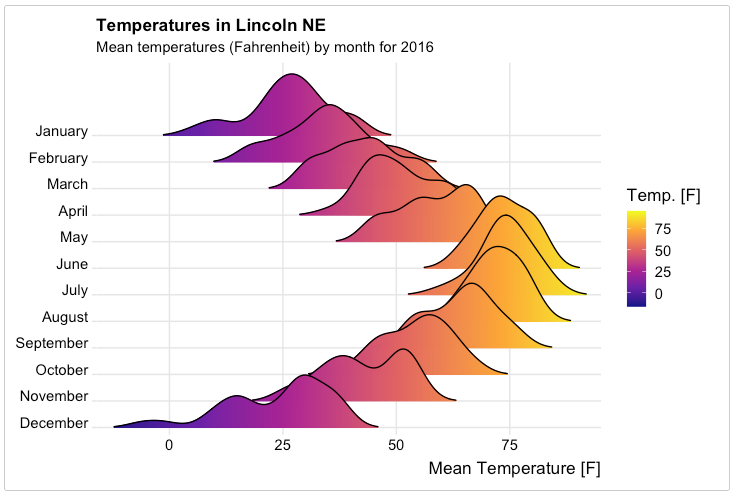

In order to do this, let's find a single station in Seattle, WA. We'll make a simple `point_within` function and use that to filter our data frame.

If you'd like to find another location, you can use this [tile calculator](http://tools.geofabrik.de/calc/#type=geofabrik_standard&bbox=-122.6,47.1,-121.7,48.1&tab=1&proj=EPSG:4326&places=1) to find a bounding box for your region. You can also use the [NOAA GSOD tool](https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-day?bbox=47.714,-122.439,47.494,-122.219) to look up a station ID.

In [5]:
# Returns whether a data point is within the provided bounding box.
# Bounding box format is [left, bottom, right, top]
# For example: http://tools.geofabrik.de/calc/#type=geofabrik_standard&bbox=-122.6,47.1,-121.7,48.1&tab=1&proj=EPSG:4326&places=1
def point_within(longitude, latitude, bounding_box):
    return (
        (longitude >= bounding_box[0]) & (longitude <= bounding_box[2]) &
        (latitude >= bounding_box[1]) & (latitude <= bounding_box[3])
    )

# Let's see if we can find stations within Seattle, WA
seattle_box = [-122.6, 47.1, -121.7, 48.1]
dfStation = df[point_within(df['longitude'], df['latitude'], seattle_box)]
dfStation.groupby(["station_id", "station_name"]).count()

,,date,longitude,latitude,mean_temp,visibility,wind_speed,precipitation,max_temp,min_temp,has_fog,has_rain,has_snow,has_hail,has_thunder,has_tornado,year
station_id,station_name,,,,,,,,,,,,,,,,
72038800469,"PIERCE CO AIRPORT THUN FIELD, WA US",333,333,333,333,333,333,333,333,333,333,333,333,333,333,333,333
72793024233,"SEATTLE TACOMA AIRPORT, WA US",333,333,333,333,333,333,333,333,333,333,333,333,333,333,333,333
72793494248,"RENTON MUNICIPAL AIRPORT, WA US",333,333,333,333,333,333,333,333,333,333,333,333,333,333,333,333
72793524234,"SEATTLE BOEING FIELD, WA US",333,333,333,333,333,333,333,333,333,333,333,333,333,333,333,333
72793724222,"EVERETT SNOHOMISH CO AIRPORT, WA US",333,333,333,333,333,333,333,333,333,333,333,333,333,333,333,333
72793894274,"TACOMA NARROWS AIRPORT, WA US",333,333,333,333,333,333,333,333,333,333,333,333,333,333,333,333
74206024207,"TACOMA MCCHORD AFB, WA US",332,332,332,332,332,332,332,332,332,332,332,332,332,332,332,332
99404899999,"TACOMA, WA US",114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114
99435099999,"WEST POINT WA, US",322,322,322,322,322,322,322,322,322,322,322,322,322,322,322,322


We do a `count()` of each `station_id` to verify that we have the right number of observations.

If this were a complete year, there should be 365 (or 366 for a leap year :)) observations. Ensure the number of observations are correct.

In [6]:
# Let's pick one station in Seattle and draw a nice plot!
dfStation = df[df["station_id"] == "72793524234"].copy()
dfStation['date'] = pd.to_datetime(dfStation['date'])
dfStation['month_name'] = dfStation['date'].dt.month_name()
dfStation['month'] = dfStation['date'].dt.month
dfStation.head()

,station_id,station_name,date,longitude,latitude,mean_temp,visibility,wind_speed,precipitation,max_temp,min_temp,has_fog,has_rain,has_snow,has_hail,has_thunder,has_tornado,year,month_name,month
2128388,72793524234,"SEATTLE BOEING FIELD, WA US",2021-01-01,-122.30083,47.53028,47.2,8.1,5.4,0.02,52.0,44.1,False,True,False,False,False,False,2021,January,1
2128389,72793524234,"SEATTLE BOEING FIELD, WA US",2021-01-02,-122.30083,47.53028,48.4,8.0,12.7,0.18,52.0,44.1,False,True,False,False,False,False,2021,January,1
2128390,72793524234,"SEATTLE BOEING FIELD, WA US",2021-01-03,-122.30083,47.53028,43.9,7.8,9.7,1.46,48.9,37.9,False,True,False,False,False,False,2021,January,1
2128391,72793524234,"SEATTLE BOEING FIELD, WA US",2021-01-04,-122.30083,47.53028,45.9,9.0,6.7,0.16,50.0,37.9,False,True,False,False,False,False,2021,January,1
2128392,72793524234,"SEATTLE BOEING FIELD, WA US",2021-01-05,-122.30083,47.53028,44.0,9.0,8.0,0.10,50.0,39.9,False,True,False,False,False,False,2021,January,1


First, let's take a quick look at the data we're going to graph. We just want to show the `mean_temp` temperature on a month-by-month basis. 

**Please note that the temperatures *are* in Fahrenheit**

In [7]:
dfStation[["date", "mean_temp"]].head()

,date,mean_temp
2128388,2021-01-01,47.2
2128389,2021-01-02,48.4
2128390,2021-01-03,43.9
2128391,2021-01-04,45.9
2128392,2021-01-05,44.0


In [8]:
dfStation[["date", "mean_temp", "month", "month_name"]].groupby("month_name").mean().sort_values(by="month")

,mean_temp,month
month_name,,
January,43.432258,1
February,40.975000,2
March,44.616129,3
April,52.413333,4
May,56.083871,5
June,66.536667,6
July,67.906452,7
August,67.290323,8
September,61.766667,9


Looks relatively reasonable, particularly for Seattle. :) 

Now, let's see what this looks like if we just try to graph a single month. In order to do this, we will use Seaborn to draw a [density plot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html).

- Step 1: Filter down to a single month
- Step 2: Draw a density plot

This shows us how many average daily temperatures (temp) in a given month of a given year fall into a certain range.
January of 2021 had a min temp of 34.9°F and a max temp of 50.8°F


count    31.000000
mean     43.432258
std       3.649419
min      34.900000
25%      41.850000
50%      43.700000
75%      45.600000
max      50.800000
Name: mean_temp, dtype: float64

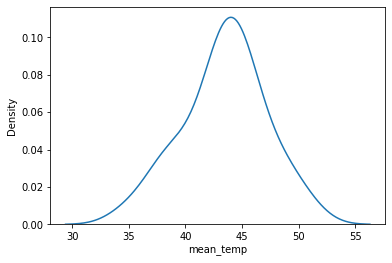

In [9]:
%matplotlib inline

import seaborn as sns

month_df = dfStation.query(f"month==1")["mean_temp"]

sns.kdeplot(month_df)

print("This shows us how many average daily temperatures (temp) in a given month of a given year fall into a certain range.")
print(f"January of {year} had a min temp of {month_df.min()}°F and a max temp of {month_df.max()}°F")
month_df.describe()

Now, we can draw a density plot for each month. We got a good idea of how to draw this grid for each month using the [seaborn documentation](https://seaborn.pydata.org/tutorial/axis_grids.html). 

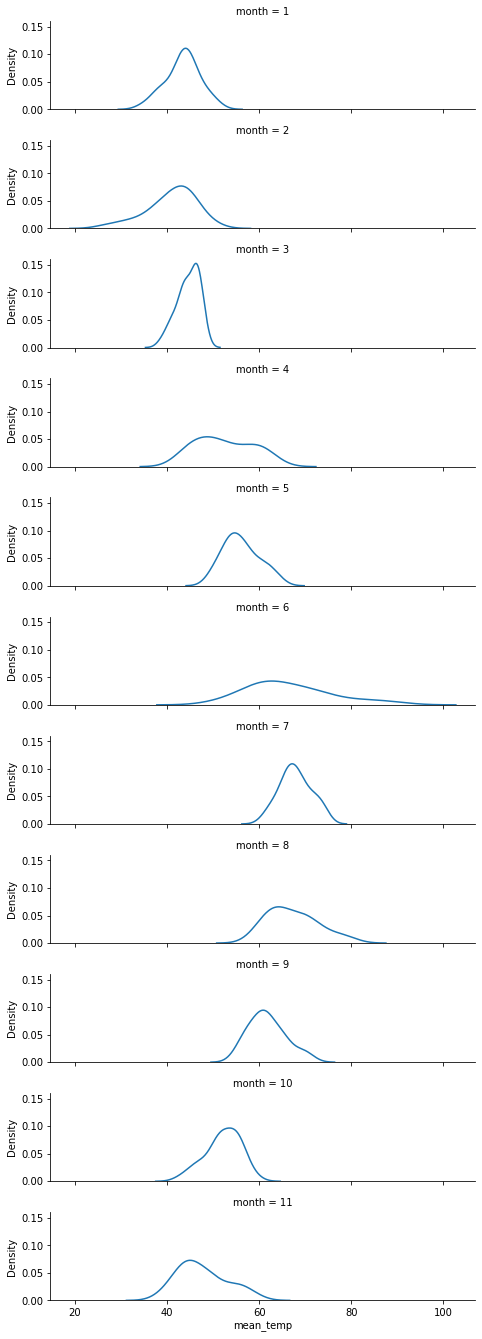

In [10]:
# Create a "FaceGrid" from the original dataframe using "month" as the facet and "mean_temp" as the column to plot.
g = sns.FacetGrid(dfStation, row="month", height=1.7, aspect=4,)
g.map(sns.kdeplot, "mean_temp")

While `R` has a great library for combining the images above ([ggridges](https://wilkelab.org/ggridges/)), we have to build this a little more manually for python.

[This post](https://jehyunlee.github.io/2021/02/11/Python-DS-61-mpl_colormapkde/) has a great way of doing this but let's step through what happening:

1. Create a matplotlib plot with 12 subplots for each month
2. Draw a density plot for the `mean_temp` of each month
3. Use `cmocean` to draw a gradient over the whole plot
4. Fetch the path of the mean temp and "clip" the colors above the line

Let's do this for one month.

1. Create a matplotlib plot with 12 subplots for each month
2. **Draw a density plot for the `mean_temp` of each month**
3. Use `cmocean` to draw a gradient over the whole plot
4. Fetch the path of the mean temp and "clip" the colors above the line

<AxesSubplot:xlabel='mean_temp', ylabel='Density'>

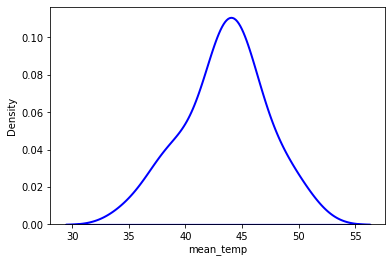

In [11]:
%matplotlib inline

import seaborn as sns

sns.kdeplot(dfStation.query(f"month==1")["mean_temp"], fill=True, color="b", alpha=0, linewidth=2, legend=False)

1. Create a matplotlib plot with 12 subplots for each month
2. Draw a density plot for the `mean_temp` of each month
3. **Use `cmocean` to draw a gradient over the whole plot**
4. Fetch the path of the mean temp and "clip" the colors above the line

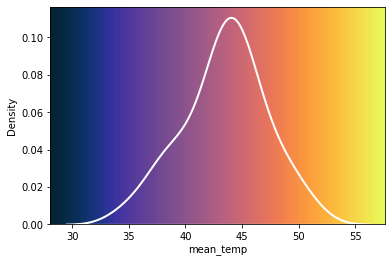

In [12]:
%matplotlib inline

import seaborn as sns
import cmocean as cmo
import numpy as np

# We use this to draw a gradient.
# 100 means we have 100 shades - try changing it to 10. :)
x = np.linspace(0, 1, 100)

ax = sns.kdeplot(
    dfStation.query(f"month==1")["mean_temp"],
    fill=True,
    color="w",  # Set the color of the line to white
    alpha=0,    # Set alpha transparency below the line to completely transparent
    linewidth=2,
    legend=False,
)

# Draw a "thermal" image over the plot with the lower/upper bounds retrieved from the axis (ax.get_xlim)
# Try different colormaps from https://matplotlib.org/cmocean/ if you want, like "cmo.amp" or "cmo.solar"
im = ax.imshow(
    np.vstack([x, x]),
    cmap="cmo.thermal",
    aspect="auto",
    extent=[*ax.get_xlim(), *ax.get_ylim()],
)

1. Create a matplotlib plot with 12 subplots for each month
2. Draw a density plot for the `mean_temp` of each month
3. Use `cmocean` to draw a gradient over the whole plot
4. **Fetch the path of the mean temp and "clip" the colors above the line**

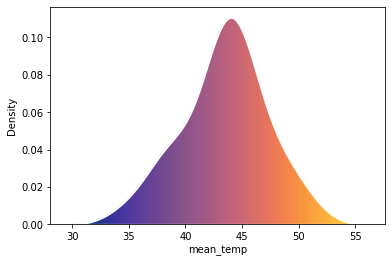

In [13]:
%matplotlib inline

import matplotlib as mpl
import seaborn as sns
import cmocean as cmo
import numpy as np

# We use this to draw a gradient.
# 100 means we have 100 shades - try changing it to 10. :)
x = np.linspace(0, 1, 100)

ax = sns.kdeplot(
    dfStation.query(f"month==1")["mean_temp"],
    fill=True,
    color="w",  # Set the color of the line to white
    alpha=0,    # Set alpha transparency below the line to completely transparent
    linewidth=2,
    legend=False,
)
im = ax.imshow(
    np.vstack([x, x]),
    cmap="cmo.thermal",
    aspect="auto",
    extent=[*ax.get_xlim(), *ax.get_ylim()],
)

# Retrieve the path of the density plot
path = ax.collections[0].get_paths()[0]

# Create a "patch" from the path then clip that from the image
patch = mpl.patches.PathPatch(path, transform=ax.transData)
im.set_clip_path(patch)

Now we'll create a figure with 12 subplots and repeat the above code for each month.

Note that in the `sns.kdeplot`, we are now providing a subplot to draw on with the `ax=ax` parameter.

In addition, we may not have a complete year so only perform the "path clipping" for months we have data for.

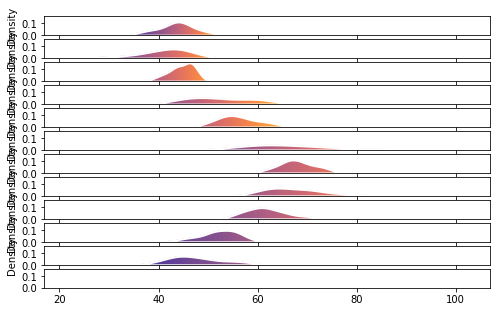

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cmocean as cmo
import numpy as np

# We use this to draw a gradient.
# 100 means we have 100 shades - try changing it to 10. :)
x = np.linspace(0, 1, 100)

fig, axs = plt.subplots(nrows=12, figsize=(8,5), sharex=True, sharey=True)

for i, ax in enumerate(axs, 1):
    month_data = dfStation.query(f"month=={i}")["mean_temp"]
    sns.kdeplot(
        month_data,
        fill=True,
        color="w",  # Set the color of the line to white
        alpha=0,    # Set alpha transparency below the line to completely transparent
        linewidth=2,
        legend=False,
        ax=ax
    )
    if month_data.count() > 0:
        im = ax.imshow(
            np.vstack([x, x]),
            cmap="cmo.thermal",
            aspect="auto",
            extent=[*ax.get_xlim(), *ax.get_ylim()],
        )

        path = ax.collections[0].get_paths()[0]
        patch = mpl.patches.PathPatch(path, transform=ax.transData)
        im.set_clip_path(patch)

OK! This looks pretty good! 

Now we need to clean up the plot by cleaning up the visualization.

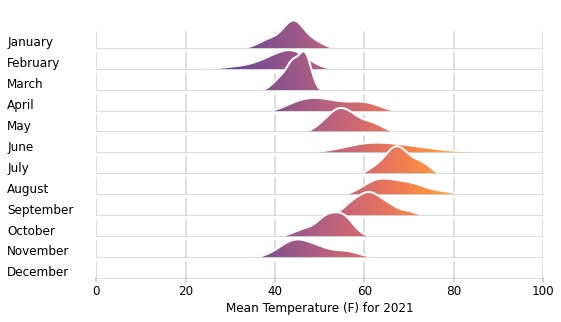

In [15]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cmocean as cmo
import calendar

# Thanks to https://jehyunlee.github.io/2021/02/11/Python-DS-61-mpl_colormapkde/ for this amazing code

# If we're plotting the current year, we won't have all 12 months
n_months = len(dfStation.groupby("month").count())
min_value = dfStation['mean_temp'].min()
max_value = dfStation['mean_temp'].max()

# First, draw all the subplots for the available months
fig, axs = plt.subplots(nrows=12, figsize=(8,5), sharex=True, sharey=True)
fig.set_facecolor("none")

# We use this to draw a gradient.
x = np.linspace(0, 1, 100)

for i, ax in enumerate(axs, 1):
    # Filter the data down to a single month and use a seaborn density plot
    month_data = dfStation.query(f"month=={i}")["mean_temp"]
    sns.kdeplot(month_data, fill=True, color="w", alpha=0, linewidth=2, legend=False, ax=ax)
    
    # We are hardcoding the temperature here between 0-100 degrees F
    ax.set_xlim(0, 100)
    
    # If we have data for this month, we do the following
    # - Draw a gradient over the whole plot
    # - Retrieve the path of the line from the density plot above
    # - Clip the gradient *above* the line so we just have our fancy color inside the line
    if i <= n_months:
        im = ax.imshow(np.vstack([x, x]), 
                   cmap="cmo.thermal",
                   aspect="auto",
                   extent=[*ax.get_xlim(), *ax.get_ylim()]
                  )
        path = ax.collections[0].get_paths()[0]
        patch = mpl.patches.PathPatch(path, transform=ax.transData)
        im.set_clip_path(patch)
    
    # Add the month name label
    ax.text(-20, 0.01, calendar.month_name[i], fontdict={"fontsize":"large"}) 
    
    # Tweak the viz a little bit to be cleaner
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(axis="x", length=0)
    
    # When we hit the bottom of the chart (12th row, December), add our tick labels and chart label
    if i == 12:
        ax.tick_params(axis="x", direction="inout", color="lightgray", 
                       length=5, width=2, labelsize="large")
        ax.set_xlabel(f"Mean Temperature (F) for {year}", fontdict={"fontsize":"large"})
    
    # No y ticks or labels
    ax.set_yticks([]) 
    ax.set_ylabel("") 
    
    # Draw vertical lines up from the bottom of each month
    for xtick in ax.get_xticks():
        ax.plot([xtick, xtick], [0, 0.065], color='lightgray', zorder=-1)
        
    # Draw a horizontal line across the bottom of the subplot
    ax.axhline(0, color="lightgray")
    ax.set_facecolor("none")
    
fig.subplots_adjust(hspace=-0.5) 

Awesome!! 

Let's make this a singular function that can take any year for which we have data.

**!!! ⚠️**

**<font color="red">MAKE SURE YOU REPLACE `<ACCOUNT_ID>` BELOW WITH THE ACCOUNT ID FROM EARLIER IN THE NOTEBOOK</font>**
    
**!!! ⚠️**

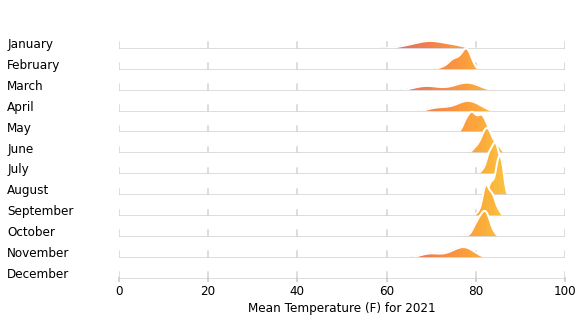

In [16]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cmocean as cmo
import calendar

# Replace with your Account ID
INPUT_BUCKET="emr-dev-exp-068216289992"

# Thanks to https://jehyunlee.github.io/2021/02/11/Python-DS-61-mpl_colormapkde/ for this amazing code
def awesome_plot(year, station_id):
    df = pd.read_parquet(f"s3://{INPUT_BUCKET}/weather_data/year={year}/")
    df = df[df["station_id"] == f"{station_id}"]
    df['date'] = pd.to_datetime(df['date'])
    df['month_name'] = df['date'].dt.month_name()
    df['month'] = df['date'].dt.month
    
    # If we're plotting the current year, we won't have all 12 months
    n_months = len(df.groupby("month").count())
    
    # First, draw all the subplots for the available months
    fig, axs = plt.subplots(nrows=12, figsize=(8,5), sharex=True, sharey=True)
    fig.set_facecolor("none")

    # We use this to draw a gradient.
    x = np.linspace(0, 1, 100)

    for i, ax in enumerate(axs, 1):
        # Filter the data down to a single month and use a seaborn density plot
        month_data = df.query(f"month=={i}")["mean_temp"]
        sns.kdeplot(month_data, fill=True, color="w", alpha=0, linewidth=2, legend=False, ax=ax)

        # We are hardcoding the temperature here between 0-100 degrees F
        ax.set_xlim(0,100)

        # If we have data for this month, we do the following
        # - Draw a gradient over the whole plot
        # - Retrieve the path of the line from the density plot above
        # - Clip the gradient *above* the line so we just have our fancy color inside the line
        if i <= n_months:
            im = ax.imshow(np.vstack([x, x]), 
                       cmap="cmo.thermal",
                       aspect="auto",
                       extent=[*ax.get_xlim(), *ax.get_ylim()]
                      )
            path = ax.collections[0].get_paths()[0]
            patch = mpl.patches.PathPatch(path, transform=ax.transData)
            im.set_clip_path(patch)

        # Add the month name label
        ax.text(-25, 0.01, calendar.month_name[i], fontdict={"fontsize":"large"}) 

        # Tweak the viz a little bit to be cleaner
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(axis="x", length=0)

        # When we hit the bottom of the chart (12th row, December), add our tick labels and chart label
        if i == 12:
            ax.tick_params(axis="x", direction="inout", color="lightgray", 
                           length=5, width=2, labelsize="large")
            ax.set_xlabel(f"Mean Temperature (F) for {year}", fontdict={"fontsize":"large"})

        # No y ticks or labels
        ax.set_yticks([]) 
        ax.set_ylabel("") 

        # Draw vertical lines up from the bottom of each month
        for xtick in ax.get_xticks():
            ax.plot([xtick, xtick], [0, 0.065], color='lightgray', zorder=-1)

        # Draw a horizontal line across the bottom of the subplot
        ax.axhline(0, color="lightgray")
        ax.set_facecolor("none")

    fig.subplots_adjust(hspace=-0.5)

# Let's try a station in Miami, FL
awesome_plot("2021", "99735599999")

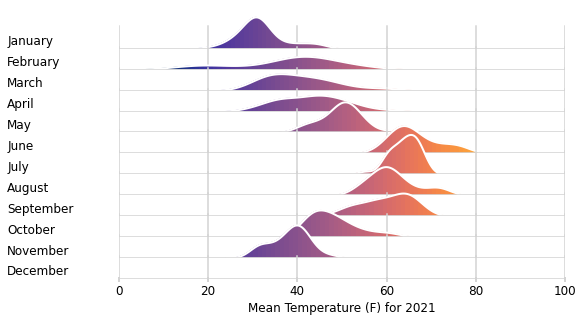

In [17]:
# Or perhaps Germany
awesome_plot("2021", "10743099999")

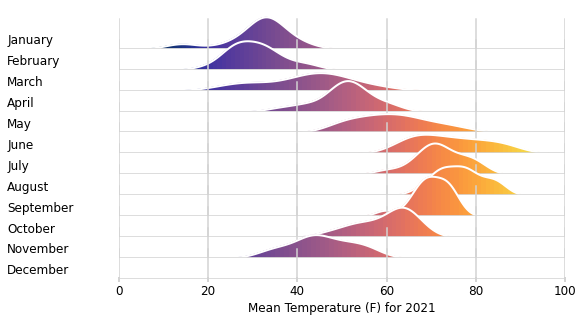

In [28]:
# AG: Looking at Boston now.
awesome_plot("2021", "72509014739")